
# FISVDD — Demo-Style QoE Anomaly Detector (Imports your `fisvdd.py`)

This notebook mirrors your **original demo style**:
- Import `fisvdd` from your own `fisvdd.py` (no class code here).
- Read a CSV to `numpy` and run `find_sv()`.
- Plot data vs. support vectors (projected to 2D with PCA for visualization).
- Save model state for reuse.
- Expose a **FastAPI** endpoint (`/predict`) to score new QoE points and optionally **incrementally learn**.


## 0) Install runtime deps (matplotlib, sklearn, fastapi, uvicorn, nest_asyncio, requests)

In [1]:

import sys
!{sys.executable} -m pip install --quiet numpy scipy pandas scikit-learn matplotlib fastapi uvicorn[standard] nest_asyncio requests


## 1) Import your `fisvdd.py` and set paths

In [3]:

# Put fisvdd.py in the **same folder** as this notebook.
from fisvdd import fisvdd

import os, pickle, numpy as np, pandas as pd
from pathlib import Path

# Cross-platform model path
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(exist_ok=True)
MODEL_PATH = MODELS_DIR / "fisvdd_qoe.pkl"
print("Model path:", MODEL_PATH.resolve())


Model path: C:\Users\ahmed\fisvvd\models\fisvdd_qoe.pkl



## 2) Load training CSV (normal-only works best)

- Set `CSV_PATH` to your QoE CSV (columns listed in `FEATURES`).  
- If you don't have one yet, this will **synthesize a small normal-only dataset** so you can run the demo end-to-end.


In [4]:

from sklearn.decomposition import PCA

# Expected QoE features (adjust to your CSV)
FEATURES = [
    "throughput_kbps",
    "startup_delay_ms",
    "rebuffer_count",
    "rebuffer_duration_s",
    "bitrate_kbps",
    "resolution_height",
    "dropped_frames_pct",
    "latency_ms",
    "buffer_health_s",
]

CSV_PATH = "qoe_normal_train.csv"  # <- change to your file path

def ensure_demo_csv(path="qoe_normal_train.csv", n=800, seed=0):
    if os.path.exists(path):
        return path
    rng = np.random.default_rng(seed)
    def make_points(n, mean, cov_scale=1.0):
        x = rng.multivariate_normal(mean, np.diag([cov_scale]*9), size=n)
        df = pd.DataFrame(x, columns=FEATURES)
        df["MOS"] = 4.5 + rng.normal(0, 0.2, size=n)
        return df
    normal = make_points(n, mean=[4000, 500, 0.1, 0.2, 3000, 1080, 0.5, 80, 15], cov_scale=200)
    df = normal[FEATURES].astype(float)
    df.to_csv(path, index=False)
    return path

CSV_PATH = ensure_demo_csv(CSV_PATH)

# Load data exactly like your demo (to numpy array)
data_df = pd.read_csv(CSV_PATH)
data = data_df[FEATURES].astype(float).values
print("Loaded:", data.shape, "from", CSV_PATH)


Loaded: (5000, 9) from qoe_normal_train.csv



## 3) Train FISVDD (demo-style)

This mirrors your original pattern:

```python
s = 0.8
fd = fisvdd(data, s)
fd.find_sv()
fd._print_res()
```


In [5]:

# --- Demo-style sigma ---
s = 0.8  # you can change this; smaller = tighter boundary, larger = looser

fd = fisvdd(data, s)
fd.find_sv()
fd._print_res()

# Keep a quick metric for plotting: objective trace
obj_vals = getattr(fd, "obj_val", [])
len(obj_vals)



alpha -------
[1]

support vector -------
[[2.19190301e+03 5.56186017e+01 0.00000000e+00 0.00000000e+00
  1.76361657e+03 7.20000000e+02 3.94959653e-01 7.29391214e+01
  2.52763878e+01]]


4999


## 4) Visualization (2D via PCA)

Your original demo plotted 2D points directly.  
QoE is multi-dimensional, so we project to 2D with **PCA** for visualization only.


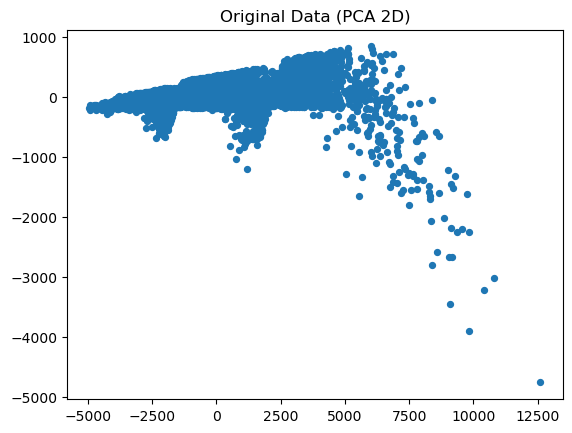

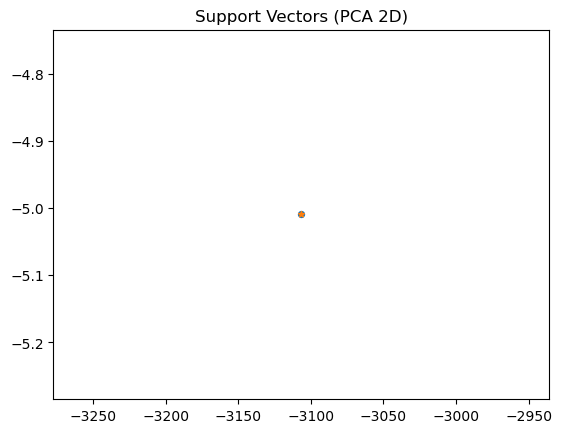

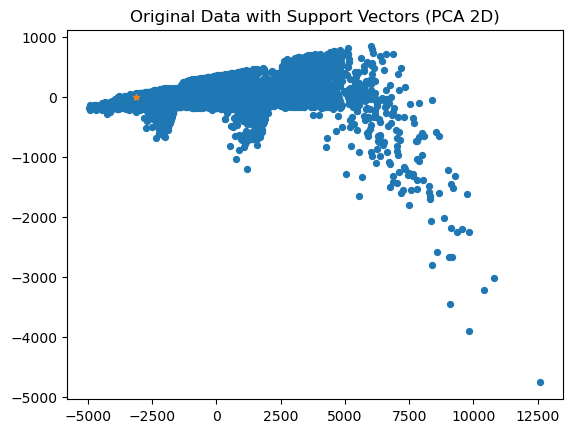

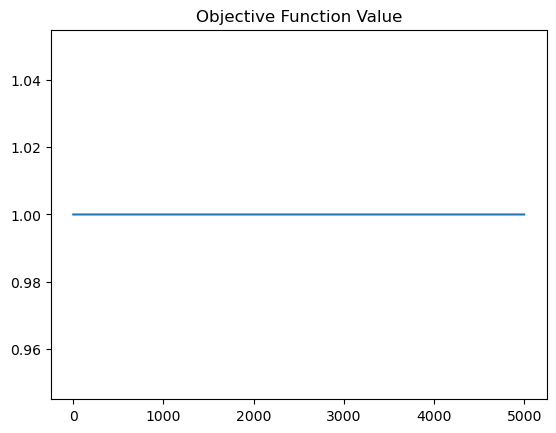

In [6]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2, random_state=0)
data_2d = pca.fit_transform(data)
sv_2d = pca.transform(fd.sv)

plt.figure()
plt.scatter(data_2d[:,0], data_2d[:,1], s=18)
plt.title("Original Data (PCA 2D)")
plt.show()

plt.figure()
plt.scatter(sv_2d[:,0], sv_2d[:,1], s=18)
plt.scatter(sv_2d[:,0], sv_2d[:,1], marker='*', s=18)
plt.title("Support Vectors (PCA 2D)")
plt.show()

plt.figure()
plt.scatter(data_2d[:,0], data_2d[:,1], s=18)
plt.scatter(sv_2d[:,0], sv_2d[:,1], marker='*', s=18)
plt.title("Original Data with Support Vectors (PCA 2D)")
plt.show()

if obj_vals:
    plt.figure()
    plt.plot(obj_vals)
    plt.title("Objective Function Value")
    plt.show()



## 5) Save trained state

We persist everything needed to rebuild the FISVDD object later for API usage.


In [7]:

to_save = {
    "features": FEATURES,
    "sv":     fd.sv,
    "alpha":  fd.alpha,
    "inv_A":  fd.inv_A,
    "score":  fd.score,
    "sigma":  fd.sigma,
    "eps_cp": fd.eps_cp,
    "eps_ol": fd.eps_ol,
}
with open(MODEL_PATH, "wb") as f:
    pickle.dump(to_save, f)
MODEL_PATH.as_posix()


'models/fisvdd_qoe.pkl'


## 6) FastAPI service (in-notebook)

Endpoints:
- `GET /status` – feature names, SV count, sigma, score scalar
- `POST /predict` – send a dict of features or a list (same order as `FEATURES`)
  - `learn=false` → classify only
  - `learn=true`  → **incrementally learn** (like your `find_sv` logic but for one point)


In [8]:

import nest_asyncio, threading, uvicorn
from fastapi import FastAPI
from pydantic import BaseModel, Field
from typing import Dict, List, Optional

nest_asyncio.apply()

# Rebuild a runtime model object from disk state
with open(MODEL_PATH, "rb") as f:
    meta = pickle.load(f)

# Dummy init then inject arrays
dummy = np.zeros((1, len(meta["features"])))
fd_rt = fisvdd(dummy, sigma=meta["sigma"], eps_cp=meta["eps_cp"], eps_ol=meta["eps_ol"])
fd_rt.sv = meta["sv"]; fd_rt.alpha = meta["alpha"]; fd_rt.inv_A = meta["inv_A"]; fd_rt.score = meta["score"]

def classify_point(fd_obj, x):
    if isinstance(x, dict):
        xv = np.array([x[k] for k in meta["features"]], dtype=float)
    else:
        xv = np.array(x, dtype=float)
    r, sim = fd_obj.score_fcn(np.array([xv]))
    max_sim = float(np.max(sim))
    if max_sim < fd_obj.eps_ol:
        return {"is_anomaly": True, "reason": "very_low_similarity", "score": float(r), "max_sim": max_sim}
    if float(r) > 0:
        return {"is_anomaly": True, "reason": "outside_boundary", "score": float(r), "max_sim": max_sim}
    return {"is_anomaly": False, "reason": "in_distribution", "score": float(r), "max_sim": max_sim}

def online_learn(fd_obj, x):
    # Mimic your incremental step for a single point
    if isinstance(x, dict):
        xv = np.array([x[k] for k in meta["features"]], dtype=float)
    else:
        xv = np.array(x, dtype=float)
    r, sim = fd_obj.score_fcn(np.array([xv]))
    expanded = False
    if float(r) > 0:
        fd_obj.expand(np.array([xv]), sim)
        expanded = True
        if np.min(fd_obj.alpha) < 0:
            backup = fd_obj.shrink()
            for each in backup:
                s2, v2 = fd_obj.score_fcn(np.array([each]))
                if s2 > 0:
                    fd_obj.expand(np.array([each]), v2)
        fd_obj.model_update()
    # persist
    meta.update({"sv": fd_obj.sv, "alpha": fd_obj.alpha, "inv_A": fd_obj.inv_A, "score": fd_obj.score})
    with open(MODEL_PATH, "wb") as f:
        pickle.dump(meta, f)
    return expanded

app = FastAPI(title="FISVDD QoE API (Demo-Style)", version="1.0.0")

class PredictRequest(BaseModel):
    features: Dict[str, float] | List[float]
    learn: bool = Field(default=False)

class PredictResponse(BaseModel):
    is_anomaly: bool
    reason: str
    score: float
    max_sim: float
    expanded: bool = False

class StatusResponse(BaseModel):
    features: List[str]
    num_svs: int
    sigma: float
    score_scalar: float

@app.get("/status", response_model=StatusResponse)
def status():
    return StatusResponse(
        features=meta["features"],
        num_svs=int(fd_rt.sv.shape[0]),
        sigma=float(fd_rt.sigma),
        score_scalar=float(fd_rt.score)
    )

@app.post("/predict", response_model=PredictResponse)
def predict(req: PredictRequest):
    res = classify_point(fd_rt, req.features)
    expanded = False
    if req.learn:
        expanded = online_learn(fd_rt, req.features)
    return PredictResponse(**res, expanded=bool(expanded))

def run_server():
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="info")

server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()

"API started on http://127.0.0.1:8000 (try /status)"


'API started on http://127.0.0.1:8000 (try /status)'

INFO:     Started server process [17472]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:62625 - "GET /status HTTP/1.1" 200 OK
INFO:     127.0.0.1:62626 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62627 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62628 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62629 - "GET /status HTTP/1.1" 200 OK
INFO:     127.0.0.1:62685 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62694 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62860 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62869 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62872 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62873 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62874 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62875 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62876 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62878 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62879 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:62881 - "POST /predict H

## 7) Quick client test

In [27]:

import requests, time, json
time.sleep(1.0)
print("STATUS:", requests.get("http://127.0.0.1:8000/status").json())

# Build a normal-ish point from the training distribution
x_ok = {k: float(data_df.iloc[0][k]) for k in FEATURES}

# Make a clearly-bad point
x_bad = {
  "throughput_kbps": 600, "startup_delay_ms": 4000, "rebuffer_count": 3,
  "rebuffer_duration_s": 12.0, "bitrate_kbps": 200, "resolution_height": 240,
  "dropped_frames_pct": 12.0, "latency_ms": 700, "buffer_health_s": 0.5
}

print("OK  →", requests.post("http://127.0.0.1:8000/predict", json={"features": x_ok,  "learn": False}).json())
print("BAD →", requests.post("http://127.0.0.1:8000/predict", json={"features": x_bad, "learn": False}).json())

# Try incremental learning on a good point
print("LEARN OK →", requests.post("http://127.0.0.1:8000/predict", json={"features": x_ok, "learn": True}).json())
print("STATUS:", requests.get("http://127.0.0.1:8000/status").json())


STATUS: {'features': ['throughput_kbps', 'startup_delay_ms', 'rebuffer_count', 'rebuffer_duration_s', 'bitrate_kbps', 'resolution_height', 'dropped_frames_pct', 'latency_ms', 'buffer_health_s'], 'num_svs': 1, 'sigma': 0.8, 'score_scalar': 1.0}
OK  → {'is_anomaly': False, 'reason': 'in_distribution', 'score': -1.0, 'max_sim': 1.0, 'expanded': False}
BAD → {'is_anomaly': True, 'reason': 'very_low_similarity', 'score': -1.0, 'max_sim': 0.0, 'expanded': False}
LEARN OK → {'is_anomaly': False, 'reason': 'in_distribution', 'score': -1.0, 'max_sim': 1.0, 'expanded': False}
STATUS: {'features': ['throughput_kbps', 'startup_delay_ms', 'rebuffer_count', 'rebuffer_duration_s', 'bitrate_kbps', 'resolution_height', 'dropped_frames_pct', 'latency_ms', 'buffer_health_s'], 'num_svs': 1, 'sigma': 0.8, 'score_scalar': 1.0}


## 7) Sending Request 

In [26]:
x_any = {
    "throughput_kbps": 5200,
    "startup_delay_ms": 300,
    "rebuffer_count": 0,
    "rebuffer_duration_s": 0.0,
    "bitrate_kbps": 3800,
    "resolution_height": 1080,
    "dropped_frames_pct": 0.3,
    "latency_ms": 90,
    "buffer_health_s": 22.0
}
print(requests.post("http://127.0.0.1:8000/predict", json={"features": x_any, "learn": False}).json())
print("STATUS:", requests.get("http://127.0.0.1:8000/status").json())

{'is_anomaly': True, 'reason': 'very_low_similarity', 'score': -1.0, 'max_sim': 0.0, 'expanded': False}
STATUS: {'features': ['throughput_kbps', 'startup_delay_ms', 'rebuffer_count', 'rebuffer_duration_s', 'bitrate_kbps', 'resolution_height', 'dropped_frames_pct', 'latency_ms', 'buffer_health_s'], 'num_svs': 1, 'sigma': 0.8, 'score_scalar': 1.0}


In [1]:
import requests
requests.get("http://127.0.0.1:8000/status").json()

requests.post(
  "http://127.0.0.1:8000/predict",
  json={"features": x_ok, "learn": False}
).json()

requests.post(
  "http://127.0.0.1:8000/predict",
  json={"features": x_bad, "learn": True}   # unguarded learning
).json()


NameError: name 'x_ok' is not defined